<a href="https://colab.research.google.com/github/Alex-U02/Zajecia/blob/main/zadanie_titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Shape: (891, 15)
   survived  pclass     sex   age  sibsp  parch     fare embarked  class  \
0         0       3    male  22.0      1      0   7.2500        S  Third   
1         1       1  female  38.0      1      0  71.2833        C  First   
2         1       3  female  26.0      0      0   7.9250        S  Third   
3         1       1  female  35.0      1      0  53.1000        S  First   
4         0       3    male  35.0      0      0   8.0500        S  Third   

     who  adult_male deck  embark_town alive  alone  
0    man        True  NaN  Southampton    no  False  
1  woman       False    C    Cherbourg   yes  False  
2  woman       False  NaN  Southampton   yes   True  
3  woman       False    C  Southampton   yes  False  
4    man        True  NaN  Southampton    no   True  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   surviv

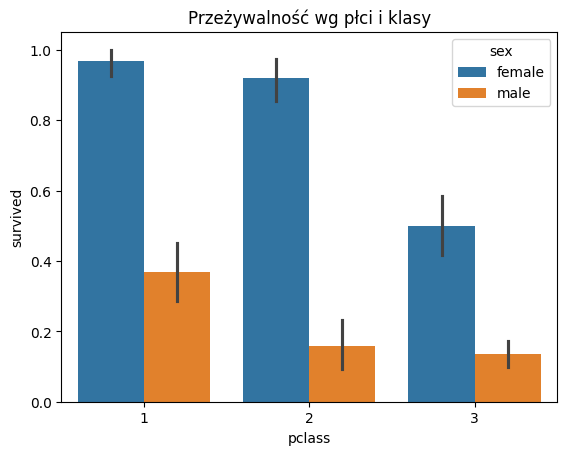


Współczynniki:
 sex_male       -2.492881
pclass         -0.799106
alone          -0.740554
sibsp          -0.440000
class_Third    -0.395307
embarked_S     -0.359462
parch          -0.302981
embarked_Q      0.260979
age            -0.036967
class_Second    0.014468
fare            0.001656
dtype: float64

Odds Ratios:
 pclass          0.449731
age             0.963708
sibsp           0.644036
parch           0.738613
fare            1.001657
alone           0.476850
sex_male        0.082671
embarked_Q      1.298201
embarked_S      0.698052
class_Second    1.014573
class_Third     0.673473
dtype: float64


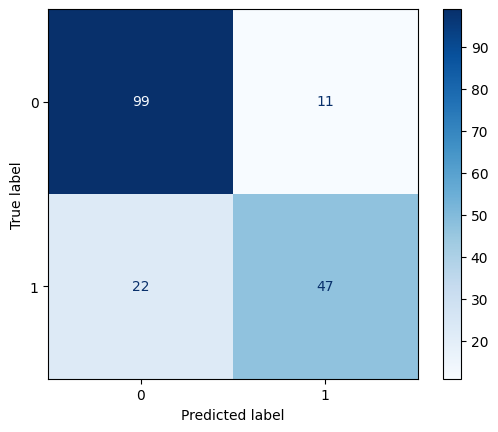

Accuracy: 0.8156424581005587
Precision: 0.8103448275862069
Recall: 0.6811594202898551
F1: 0.7401574803149606
Specificity: 0.9
AUC: 0.8644268774703557


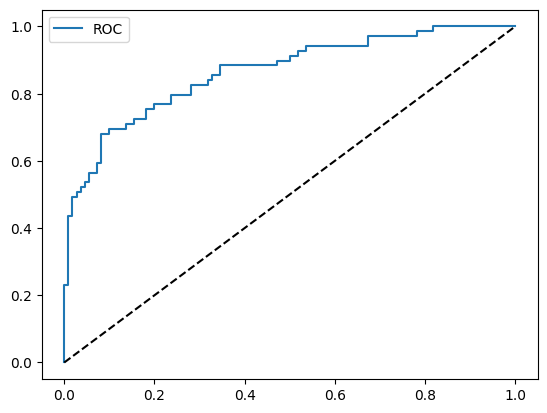

thr=0.3: Precision=0.671, Recall=0.768
thr=0.4: Precision=0.746, Recall=0.725
thr=0.5: Precision=0.810, Recall=0.681
thr=0.6: Precision=0.837, Recall=0.594
thr=0.7: Precision=0.900, Recall=0.522
AUC balanced: 0.8653491436100131
C=0.001: AUC=0.838, sum|β|=0.547
C=0.01: AUC=0.856, sum|β|=1.969
C=0.1: AUC=0.866, sum|β|=3.540
C=1: AUC=0.864, sum|β|=4.149
C=10: AUC=0.864, sum|β|=4.236
C=100: AUC=0.864, sum|β|=4.246

Porównanie L1 vs L2:
                     L2        L1
pclass       -0.450664 -0.637927
age          -0.396130 -0.302144
sibsp        -0.351931 -0.141346
parch        -0.198950 -0.035304
fare          0.091952  0.000000
alone        -0.292248 -0.039910
sex_male     -1.114116 -1.115217
embarked_Q    0.069021  0.000000
embarked_S   -0.172793 -0.159265
class_Second -0.041569  0.000000
class_Third  -0.360640 -0.128618


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve
)
from sklearn.preprocessing import StandardScaler

df = sns.load_dataset('titanic')
print("Shape:", df.shape)
print(df.head())

print(df.info())
print(df.describe().T)
print(df.isna().sum())

print("Proporcja przeżycia ogółem:", df['survived'].mean())
print("Przeżycie wg płci:\n", df.groupby('sex')['survived'].mean())
print("Przeżycie wg klasy:\n", df.groupby('pclass')['survived'].mean())

sns.barplot(data=df, x='pclass', y='survived', hue='sex', estimator=np.mean)
plt.title("Przeżywalność wg płci i klasy")
plt.show()

drop_cols = ['deck', 'embark_town', 'alive', 'who', 'adult_male']
df = df.drop(columns=[c for c in drop_cols if c in df.columns])

df['age'] = df['age'].fillna(df['age'].median())
df['embarked'] = df['embarked'].fillna(df['embarked'].mode()[0])

X = df[['pclass','sex','age','sibsp','parch','fare','embarked','class','alone']]
y = df['survived'].astype(int)

X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y
)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

coefs = pd.Series(model.coef_[0], index=X.columns).sort_values(key=np.abs, ascending=False)
print("\nWspółczynniki:\n", coefs)

odds_ratios = np.exp(model.coef_[0])
print("\nOdds Ratios:\n", pd.Series(odds_ratios, index=X.columns))

y_proba = model.predict_proba(X_test)[:,1]
y_pred = (y_proba >= 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap="Blues")
plt.show()

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
tn, fp, fn, tp = cm.ravel()
print("Specificity:", tn/(tn+fp))
print("AUC:", roc_auc_score(y_test, y_proba))

fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label="ROC")
plt.plot([0,1],[0,1],'k--')
plt.legend()
plt.show()

for thr in [0.3,0.4,0.5,0.6,0.7]:
    y_pred_thr = (y_proba >= thr).astype(int)
    print(f"thr={thr}: Precision={precision_score(y_test,y_pred_thr):.3f}, Recall={recall_score(y_test,y_pred_thr):.3f}")

model_bal = LogisticRegression(max_iter=1000, class_weight='balanced')
model_bal.fit(X_train, y_train)
print("AUC balanced:", roc_auc_score(y_test, model_bal.predict_proba(X_test)[:,1]))

scaler = StandardScaler()
X_train_std = X_train.copy()
X_test_std = X_test.copy()
num_cols = X_train.columns
X_train_std[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test_std[num_cols] = scaler.transform(X_test[num_cols])

for C in [0.001,0.01,0.1,1,10,100]:
    m = LogisticRegression(C=C, penalty='l2', solver='lbfgs', max_iter=1000)
    m.fit(X_train_std, y_train)
    auc = roc_auc_score(y_test, m.predict_proba(X_test_std)[:,1])
    print(f"C={C}: AUC={auc:.3f}, sum|β|={np.sum(np.abs(m.coef_[0])):.3f}")

m_l2 = LogisticRegression(C=0.1, penalty='l2', solver='lbfgs', max_iter=1000)
m_l1 = LogisticRegression(C=0.1, penalty='l1', solver='liblinear', max_iter=1000)
m_l2.fit(X_train_std, y_train)
m_l1.fit(X_train_std, y_train)

coef_comp = pd.DataFrame({
    "L2": m_l2.coef_[0],
    "L1": m_l1.coef_[0]
}, index=X_train.columns)
print("\nPorównanie L1 vs L2:\n", coef_comp)
